<a href="https://colab.research.google.com/github/G544/galinanana_ml/blob/main/kaggle/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"galinanana","key":"8147c232cb591bab100fb9318cb5ce2d"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 16.8MB/s]


In [4]:
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import numpy as np
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as plt 
import matplotlib.pyplot as plt
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

# Чтение данных


In [5]:
filezip = '/content/titanic.zip'

z = ZipFile(filezip)
print(z.infolist())
with ZipFile(filezip, 'r') as zip_file:
    zip_file.extract('train.csv', '.')
    zip_file.extract('test.csv', '.')
    zip_file.extract('gender_submission.csv', '.')

[<ZipInfo filename='gender_submission.csv' compress_type=deflate file_size=3258 compress_size=872>, <ZipInfo filename='test.csv' compress_type=deflate file_size=28629 compress_size=11171>, <ZipInfo filename='train.csv' compress_type=deflate file_size=61194 compress_size=22388>]


# First View

In [180]:
data = pd.read_csv('/content/train.csv')
data.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
675,676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,349912,7.7750,NaN,S
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S


Вещественные признаки : Age, Fare  
Категориальные : Sibsp, Cabin, Embarked, Sex, Parch, Pclass


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


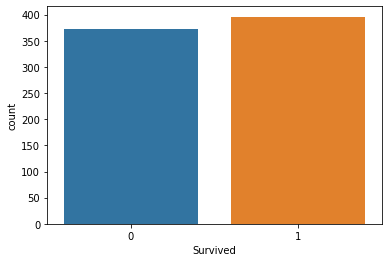

In [148]:
sns.countplot(x='Survived',data=data)
plt.show()

Классы несбалансированы

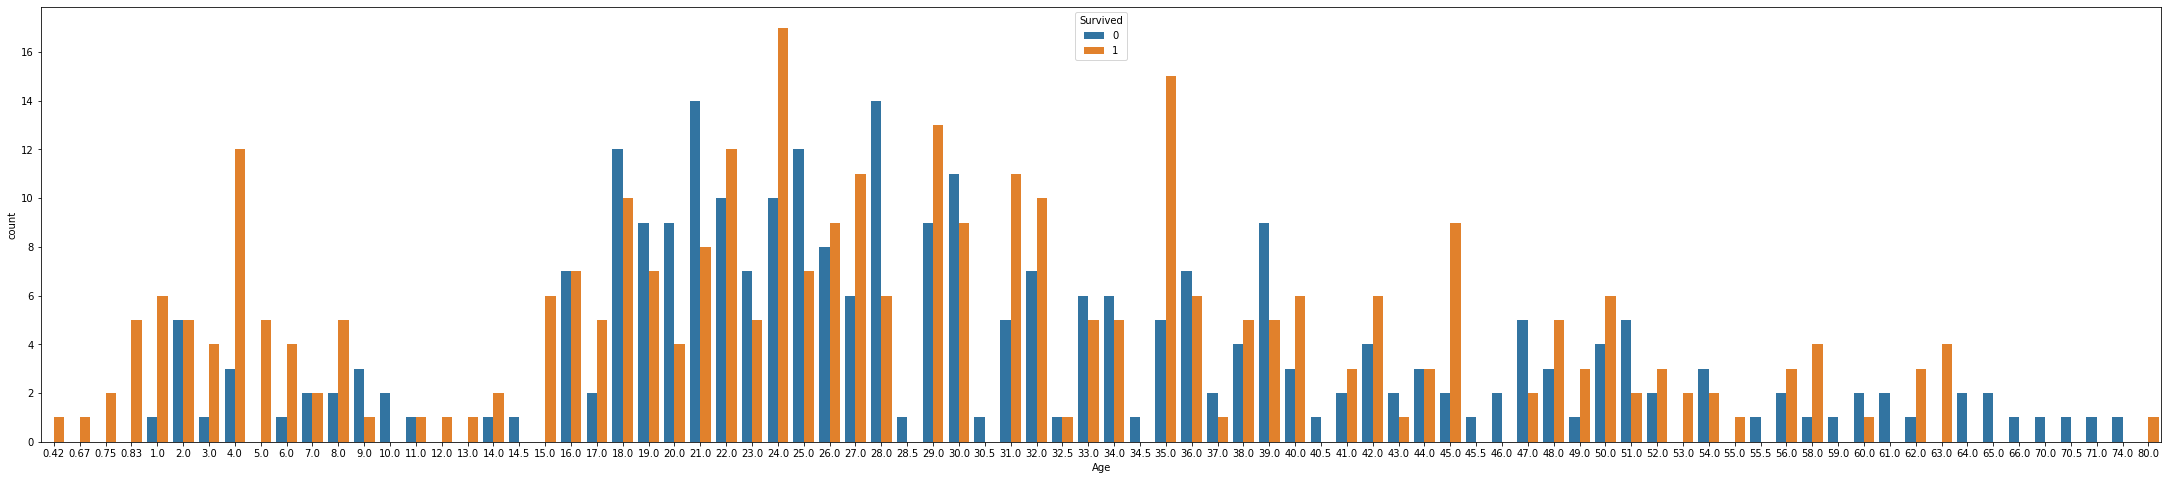

In [149]:
plt.figure(figsize=(38,8))
sns.countplot(x='Age', hue='Survived', data=data);

По графику видно, что до года выживали все. С года до 6 тоже выживаемость была чуть выше, чем у остальных, а начиная с 63 лет умирали все.

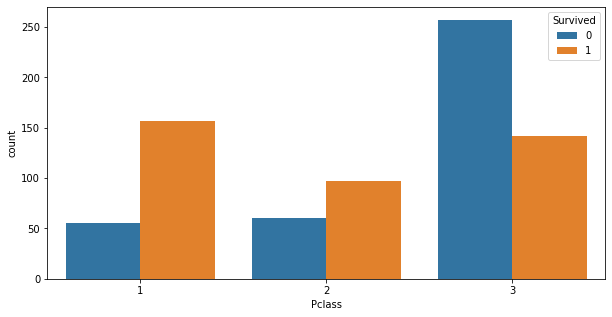

In [150]:
plt.figure(figsize=(10,5))
sns.countplot(x='Pclass', hue='Survived', data=data);

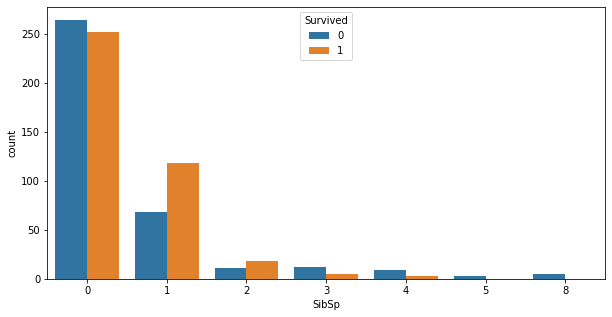

In [151]:
plt.figure(figsize=(10,5))
sns.countplot(x='SibSp', hue='Survived', data=data);

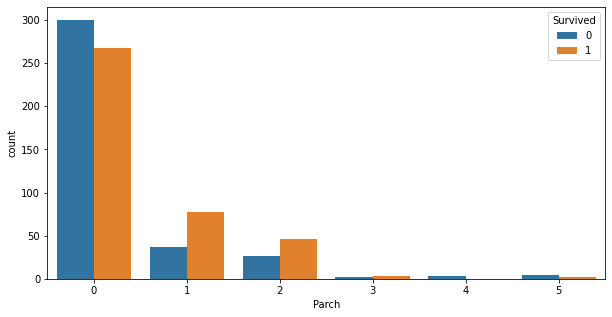

In [152]:
plt.figure(figsize=(10,5))
sns.countplot(x='Parch', hue='Survived', data=data)

# Features extraction


In [181]:
target = data['Survived']
data.drop('Survived', axis=1, inplace = True)

In [183]:
max_corr = abs(data.corr()['Age']).sort_values().index[-3:-1]
corr_df = data[~data['Age'].isna()][max_corr]
corr_target = data[~data['Age'].isna()]['Age']
lr_corr = LinearRegression()
lr_corr.fit(corr_df, corr_target)
def preproc(data):
  global lr_corr
  data['Cabin_ffil'] =( ~data['Cabin'].isna()).astype(int)
  data['Ticket_digit'] = [s[0].isdigit() for s in data['Ticket']]
  data['Ticket_digit'] = data['Ticket_digit'].astype(int)
  data['Embarked'].fillna('Nan', inplace=True)
 # data['Age'].fillna(24.0, inplace=True)
  #data['Age'].fillna(data['Age'].mean(), inplace=True)
  data['Age'] = data['Age'].fillna(dict(zip(data.loc[data['Age'].isna()].index, list(lr_corr.predict(data[data['Age'].isna()][max_corr])))))
  data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True, axis=1)
  data['SibSp'] = data['SibSp'].astype(str)
  data['Parch'] = data['SibSp'].astype(str)
  data['Pclass'] = data['SibSp'].astype(str)
  df = pd.concat([data,pd.get_dummies(data[['Sex', 'Embarked', 'Pclass', 'SibSp','Parch']])], axis=1)
  df.drop(['Sex', 'Embarked','Pclass', 'SibSp','Parch'], axis=1, inplace=True)
  if 'Embarked_Nan' in list(df.columns):
    df.drop('Embarked_Nan', axis=1, inplace=True)
  df.fillna(0, inplace=True)
  sc = StandardScaler()
  df = sc.fit_transform(df)
  df = pd.DataFrame(columns = sc.get_feature_names_out(),data = df)
  return df

In [184]:
df = preproc(data)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(df, target)
X_train, X_test, y_train,  y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
#X_train, X_test, y_train,  y_test = train_test_split(df, target, test_size=0.3)

In [185]:
logreg = LogisticRegression()
ridge = RidgeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
logreg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
nb.fit(X_train, y_train)
rf.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_pred_rd = ridge.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [186]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
for y, name in zip((y_pred_lr, y_pred_rd, y_pred_nb, y_pred_rf), ('lr', 'ridge', 'nb','rf')):
  pred_ac = round(accuracy_score(y, y_test),3)
  pred_pr = round(precision_score(y, y_test),3)
  pred_recall = round(recall_score(y, y_test),3)
  pred_f = round(f1_score(y, y_test),3)
  pred_roc = round(roc_auc_score(y, y_test),3)
  print(f'Score for {name}  ')
  print('')
  print(f'Accuracy для {name} {pred_ac}  ')
  print(f'Precision для {name} {pred_pr}  ')
  print(f'Recall для {name} {pred_recall}  ')
  print('')

Score for lr  

Accuracy для lr 0.776  
Precision для lr 0.759  
Recall для lr 0.796  

Score for ridge  

Accuracy для ridge 0.773  
Precision для ridge 0.729  
Recall для ridge 0.81  

Score for nb  

Accuracy для nb 0.552  
Precision для nb 0.982  
Recall для nb 0.535  

Score for rf  

Accuracy для rf 0.836  
Precision для rf 0.9  
Recall для rf 0.805  



In [121]:
test = pd.read_csv('/content/test.csv')
id = test['PassengerId']
X_submiss = preproc(test)
diff = list(set(X_train.columns).difference(set(X_submiss.columns)))
dict_idx = ()
for itm in diff:
  idx = list(X_train.columns).index(itm)
  X_submiss.insert(idx, itm, 0)
submission_lr = logreg.predict(X_submiss)
submission_rd = ridge.predict(X_submiss)
submission_nb = nb.predict(X_submiss)
submission_rf = rf.predict(X_submiss)

In [122]:
d = {'PassengerId':id, 'Survived':submission_lr}
log_reg_df = pd.DataFrame(d)
d = {'PassengerId':id, 'Survived':submission_rd}
ridge_df = pd.DataFrame(d)
d = {'PassengerId':id, 'Survived':submission_nb}
nb_df = pd.DataFrame(d)
d = {'PassengerId':id, 'Survived':submission_rf}
rf_df = pd.DataFrame(d)

In [123]:
log_reg_df.to_csv('lr_submiss.csv', index=False)
ridge_df.to_csv('rd_submiss.csv', index=False)
nb_df.to_csv('nb_submiss.csv', index=False)
rf_df.to_csv('rf_submiss.csv', index=False)

In [124]:
!kaggle competitions submit -c titanic -f lr_submiss.csv -m Balance_cat_feat
#!kaggle competitions submit -c titanic -f rd_submiss.csv -m Message
!kaggle competitions submit -c titanic -f nb_submiss.csv -m Balance_cat_feat
!kaggle competitions submit -c titanic -f rf_submiss.csv -m Balance_cat_feat

100% 2.77k/2.77k [00:00<00:00, 2.90kB/s]
100% 2.77k/2.77k [00:01<00:00, 1.73kB/s]
100% 2.77k/2.77k [00:00<00:00, 3.18kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

Результаты бейзлайна  
Score for {name} lr  
Accuracy для {name} {pred_ac} lr 0.686567164179104  
Accuracy для {name} {pred_pr
 lr 0.6857142857142857  
Accuracy для {name} {pred_recall} lr 0.7128712871287128  

Score for {name} ridge

Accuracy для {name} {pred_ac} ridge 0.7649253731343284
Accuracy для {name} {pred_pr} ridge 0.6857142857142857
Accuracy для {name} {pred_recall} ridge 0.7058823529411765

Score for {name} nb

Accuracy для {name} {pred_ac} nb 0.7761194029850746
Accuracy для {name} {pred_pr} nb 0.7333333333333333
Accuracy для {name} {pred_recall} nb 0.7064220183486238


С использованием стандартскейлер

Score for lr  
(Стало лучще для всех кроме байеса)

Accuracy для lr 0.836  
Precision для lr 0.777  
Recall для lr 0.792  

Score for ridge  

Accuracy для ridge 0.817  
Precision для ridge 0.738  
Recall для ridge 0.776  

Score for nb  

Accuracy для nb 0.642  
Precision для nb 0.107  
Recall для nb 0.733  

Score for rf  

Accuracy для rf 0.81  
Precision для rf 0.738  
Recall для rf 0.76 


С другим заполнением age 24 и embarked Nan
( Стало хуже для лог регрессии и ridge, но улучшилось для леса и байеса)

from sklearn.metrics import accuracy_score, precision_score, recall_score
for y, name in zip((y_pred_lr, y_pred_rd, y_pred_nb, y_pred_rf), ('lr', 'ridge', 'nb','rf')):
  pred_ac = round(accuracy_score(y, y_test),3)
  pred_pr = round(precision_score(y, y_test),3)
  pred_recall = round(recall_score(y, y_test),3)
  print(f'Score for {name}  ')
  print('')
  print(f'Accuracy для {name} {pred_ac}  ')
  print(f'Precision для {name} {pred_pr}  ')
  print(f'Recall для {name} {pred_recall}  ')

Score for lr  

Accuracy для lr 0.799  
Precision для lr 0.717  
Recall для lr 0.732  

Score for ridge  

Accuracy для ridge 0.799  
Precision для ridge 0.677  
Recall для ridge 0.753  

Score for nb  

Accuracy для nb 0.81  
Precision для nb 0.697  
Recall для nb 0.767  

Score for rf  

Accuracy для rf 0.825  
Precision для rf 0.768  
Recall для rf 0.76  

С другим заполнением age средним и embarked Nan
(Стало хуже, чем когда age==24)
Score for lr  

Accuracy для lr 0.78  
Precision для lr 0.688  
Recall для lr 0.681  

Score for ridge  

Accuracy для ridge 0.772  
Precision для ridge 0.656  
Recall для ridge 0.678  

Score for nb  

Accuracy для nb 0.787  
Precision для nb 0.71  
Recall для nb 0.688  

Score for rf  

Accuracy для rf 0.799  
Precision для rf 0.71  
Recall для rf 0.71  

С другим заполнением age с помощью линейной регрессии и признаков PClass и Sibsp и embarked Nan
(Немножко улучшилось)
Accuracy для lr 0.806  
Precision для lr 0.685  
Recall для lr 0.804  

Score for ridge  

Accuracy для ridge 0.813  
Precision для ridge 0.694  
Recall для ridge 0.815  

Score for nb  

Accuracy для nb 0.799  
Precision для nb 0.741  
Recall для nb 0.755  

Score for rf  

Accuracy для rf 0.799  
Precision для rf 0.713  
Recall для rf 0.77  

Последний пункт плюс добавила признаки отсутвуют записи для всех признаков с проущенными занчениями
(Стало хуже для всех и сильно хуже для Байеса)
Score for lr  

Accuracy для lr 0.784  
Precision для lr 0.664  
Recall для lr 0.827  

Score for ridge  

Accuracy для ridge 0.772  
Precision для ridge 0.656  
Recall для ridge 0.808  

Score for nb  

Accuracy для nb 0.601  
Precision для nb 0.156  
Recall для nb 0.826  

Score for rf  

Accuracy для rf 0.776  
Precision для rf 0.697  
Recall для rf 0.787  

Предпоследний пункт плюс добавила признаки отсутвуют записи для Cabin
(Байес снова жив Урааа! Наблюдается улучшение для случайного леса, для остальных ухудшение, но не сильно)

Score for lr  

Accuracy для lr 0.806  
Precision для lr 0.67  
Recall для lr 0.735  

Score for ridge  

Accuracy для ridge 0.802  
Precision для ridge 0.637  
Recall для ridge 0.744  

Score for nb  

Accuracy для nb 0.769  
Precision для nb 0.692  
Recall для nb 0.649  

Score for rf  

Accuracy для rf 0.832  
Precision для rf 0.714  
Recall для rf 0.774  

Oversampling
(Улучшилось для случайного леса, но почему то в кэгл стало хуже)
Score for lr  

Accuracy для lr 0.803  
Precision для lr 0.795  
Recall для lr 0.779  

Score for ridge  

Accuracy для ridge 0.806  
Precision для ridge 0.775  
Recall для ridge 0.796  

Score for nb  

Accuracy для nb 0.785  
Precision для nb 0.768  
Recall для nb 0.763  

Score for rf  

Accuracy для rf 0.864  
Precision для rf 0.914  
Recall для rf 0.812  
